# Stock Price Prediction using LSTM Neural Network

This notebook demonstrates stock price prediction using Long Short-Term Memory (LSTM) neural networks.

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Stock data fetching
import yfinance as yf

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## 2. Fetch Stock Data

In [2]:
# Define stock ticker and date range
STOCK_TICKER = 'AAPL'  # Apple Inc. - Change this to any stock ticker
START_DATE = '2015-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

print(f"Fetching data for {STOCK_TICKER} from {START_DATE} to {END_DATE}...")

# Fetch stock data
df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)

# Flatten column names if multi-index
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

print(f"\nData shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Fetching data for AAPL from 2015-01-01 to 2025-12-08...


[*********************100%***********************]  1 of 1 completed


Data shape: (2749, 5)

First few rows:


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.237549,24.705318,23.798599,24.694233,212818400
2015-01-05,23.554743,24.086803,23.368523,24.006994,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887278,23.987038,23.654501,23.765347,160423600
2015-01-08,24.805079,24.862719,24.097882,24.215380,237458000


In [3]:
# Display basic information
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2749 entries, 2015-01-02 to 2025-12-05
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2749 non-null   float64
 1   High    2749 non-null   float64
 2   Low     2749 non-null   float64
 3   Open    2749 non-null   float64
 4   Volume  2749 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 128.9 KB
None

Basic Statistics:


Price,Close,High,Low,Open,Volume
count,2749.000000,2749.000000,2749.000000,2749.000000,2.749000e+03
mean,105.284899,106.333878,104.131145,105.184960,1.118374e+08
std,73.360801,74.070466,72.568455,73.272608,6.798817e+07
min,20.604084,20.907414,20.405662,20.526533,2.013560e+07
25%,36.531403,36.877982,36.278962,36.610748,6.539760e+07
50%,85.381752,86.186859,84.688188,85.231399,9.481230e+07
75%,167.930115,169.345494,166.640640,167.756724,1.374632e+08
max,286.190002,288.619995,283.299988,286.200012,6.488252e+08


## 3. Data Exploration and Visualization

In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Fill any missing values with forward fill
df = df.fillna(method='ffill')

Missing values:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


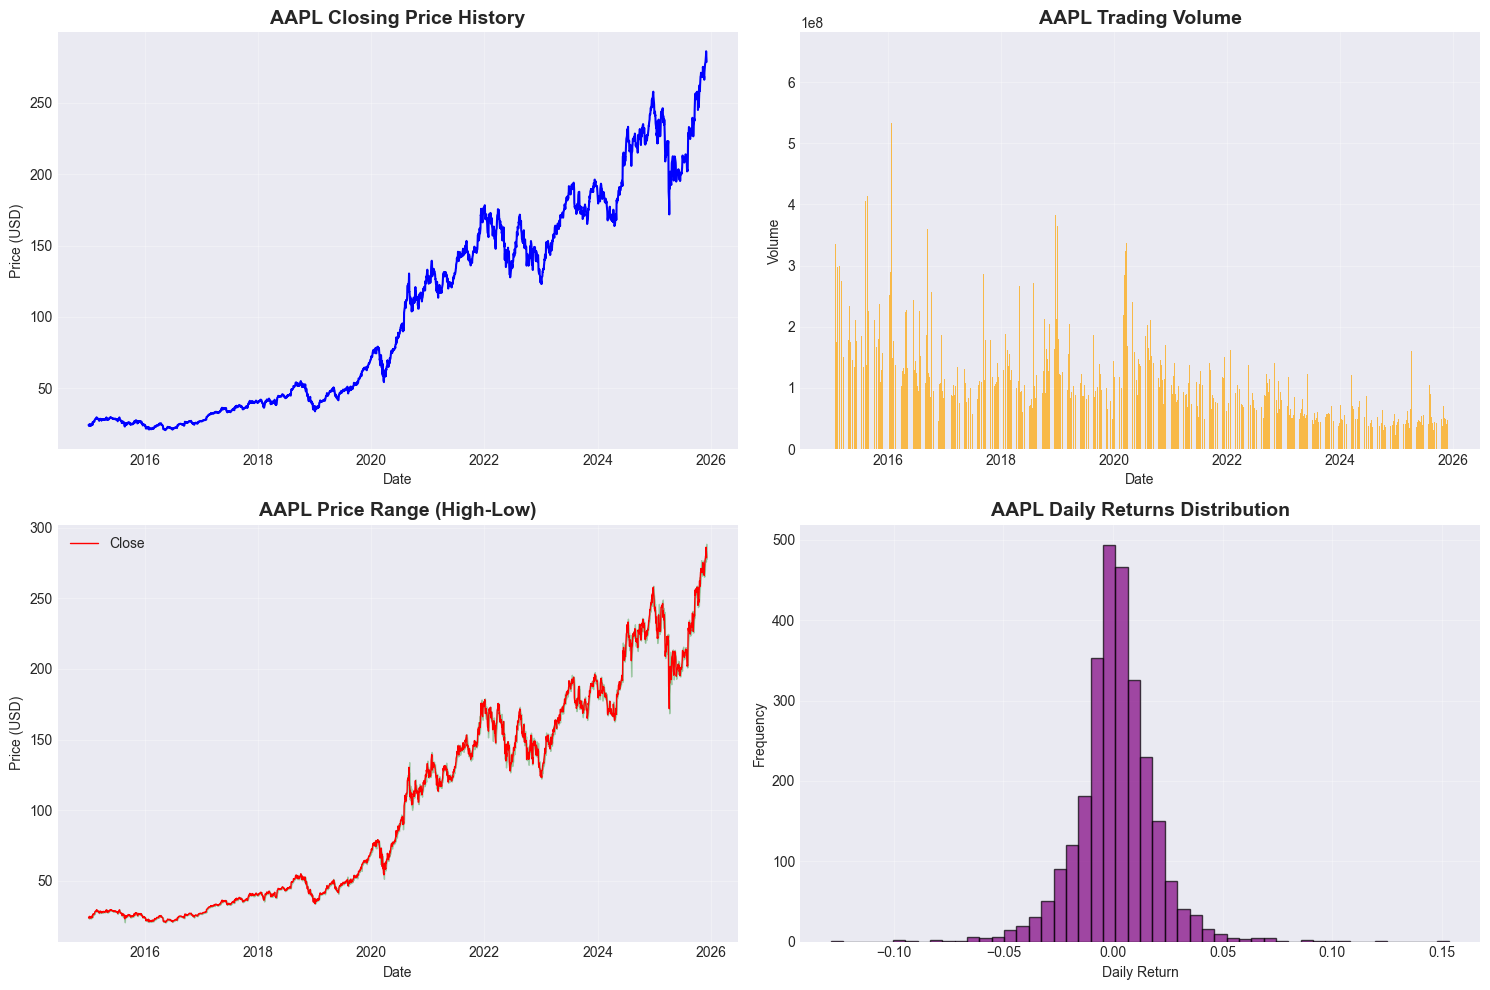

In [5]:
# Visualize stock price history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Closing price
axes[0, 0].plot(df.index, np.array(df['Close'], dtype=float), color='blue', linewidth=1.5)
axes[0, 0].set_title(f'{STOCK_TICKER} Closing Price History', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].grid(True, alpha=0.3)

# Trading volume
axes[0, 1].bar(df.index, np.array(df['Volume'], dtype=float), color='orange', alpha=0.7)
axes[0, 1].set_title(f'{STOCK_TICKER} Trading Volume', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# High-Low range
axes[1, 0].fill_between(df.index, np.array(df['Low'], dtype=float), np.array(df['High'], dtype=float), color='green', alpha=0.3)
axes[1, 0].plot(df.index, np.array(df['Close'], dtype=float), color='red', linewidth=1, label='Close')
axes[1, 0].set_title(f'{STOCK_TICKER} Price Range (High-Low)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Price (USD)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Daily returns distribution
df['Daily_Return'] = df['Close'].pct_change()
axes[1, 1].hist(np.array(df['Daily_Return'].dropna(), dtype=float), bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title(f'{STOCK_TICKER} Daily Returns Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Daily Return')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

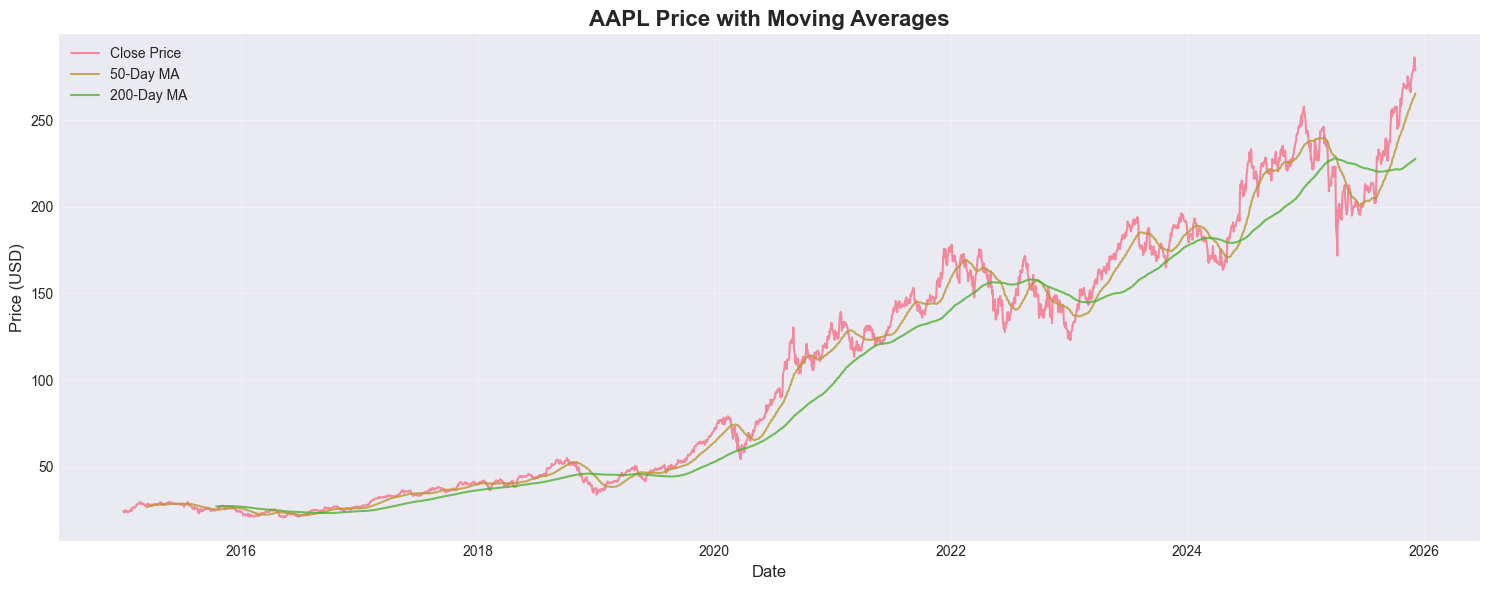

In [6]:
# Moving averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(15, 6))
plt.plot(df.index, np.array(df['Close'], dtype=float), label='Close Price', linewidth=1.5, alpha=0.8)
plt.plot(df.index, np.array(df['MA50'], dtype=float), label='50-Day MA', linewidth=1.5, alpha=0.8)
plt.plot(df.index, np.array(df['MA200'], dtype=float), label='200-Day MA', linewidth=1.5, alpha=0.8)
plt.title(f'{STOCK_TICKER} Price with Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing for LSTM

In [7]:
# Select the feature we want to predict (Close price)
data = df[['Close']].copy()

# Scale the data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"Original data shape: {data.shape}")
print(f"Scaled data shape: {scaled_data.shape}")
print(f"\nScaled data range: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")

Original data shape: (2749, 1)
Scaled data shape: (2749, 1)

Scaled data range: [0.0000, 1.0000]


In [8]:
# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Use 60 days of historical data to predict the next day
SEQUENCE_LENGTH = 60

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

print(f"Total sequences: {len(X)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Total sequences: 2689
X shape: (2689, 60)
y shape: (2689,)


In [9]:
# Split data into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Reshape for LSTM input [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Test set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

Training set: X_train shape = (2151, 60, 1), y_train shape = (2151,)
Test set: X_test shape = (538, 60, 1), y_test shape = (538,)


## 5. Build LSTM Model

In [10]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 1)),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [11]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train the model
print("Training the model...\n")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")

Training the model...

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0052 - mae: 0.0417 - val_loss: 0.0027 - val_mae: 0.0467 - learning_rate: 0.0010
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0609e-04 - mae: 0.0188 - val_loss: 0.0011 - val_mae: 0.0294 - learning_rate: 0.0010
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.1800e-04 - mae: 0.0166 - val_loss: 0.0017 - val_mae: 0.0368 - learning_rate: 0.0010
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8829e-04 - mae: 0.0169 - val_loss: 0.0017 - val_mae: 0.0360 - learning_rate: 0.0010
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7622e-04 - mae: 0.0165 - val_loss: 9.4296e-04 - val_mae: 0.0270 - learning_rate: 0.0010
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3732e-04 - mae: 0.0173 - val_loss: 8.1683e-04 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2162e-04 - mae: 0.0168 - val_loss: 

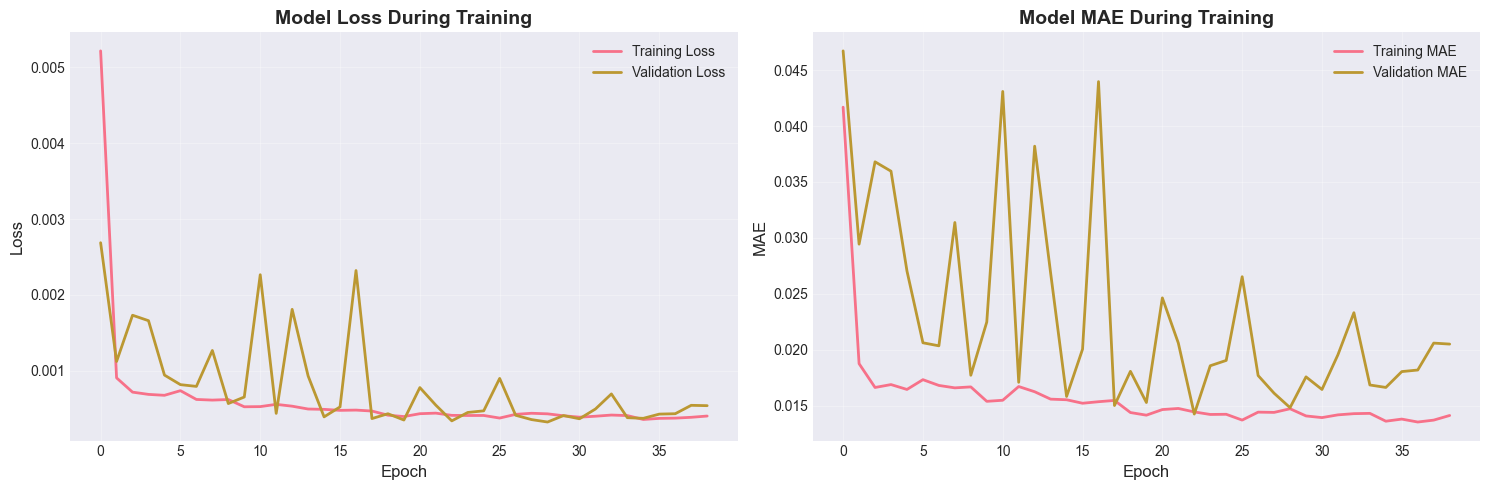

In [12]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# MAE
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_title('Model MAE During Training', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Model Evaluation

In [13]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform to get actual prices
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Predictions completed!")

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predictions completed!


In [14]:
# Calculate evaluation metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

train_metrics = calculate_metrics(y_train_actual, train_predictions)
test_metrics = calculate_metrics(y_test_actual, test_predictions)

print("="*60)
print("TRAINING SET METRICS")
print("="*60)
for metric, value in train_metrics.items():
    print(f"{metric:10s}: {value:.4f}")

print("\n" + "="*60)
print("TEST SET METRICS")
print("="*60)
for metric, value in test_metrics.items():
    print(f"{metric:10s}: {value:.4f}")
print("="*60)

TRAINING SET METRICS
MSE       : 12.8857
RMSE      : 3.5897
MAE       : 2.4051
R2        : 0.9956
MAPE      : 3.1062

TEST SET METRICS
MSE       : 102.5188
RMSE      : 10.1252
MAE       : 7.8989
R2        : 0.8704
MAPE      : 3.5553


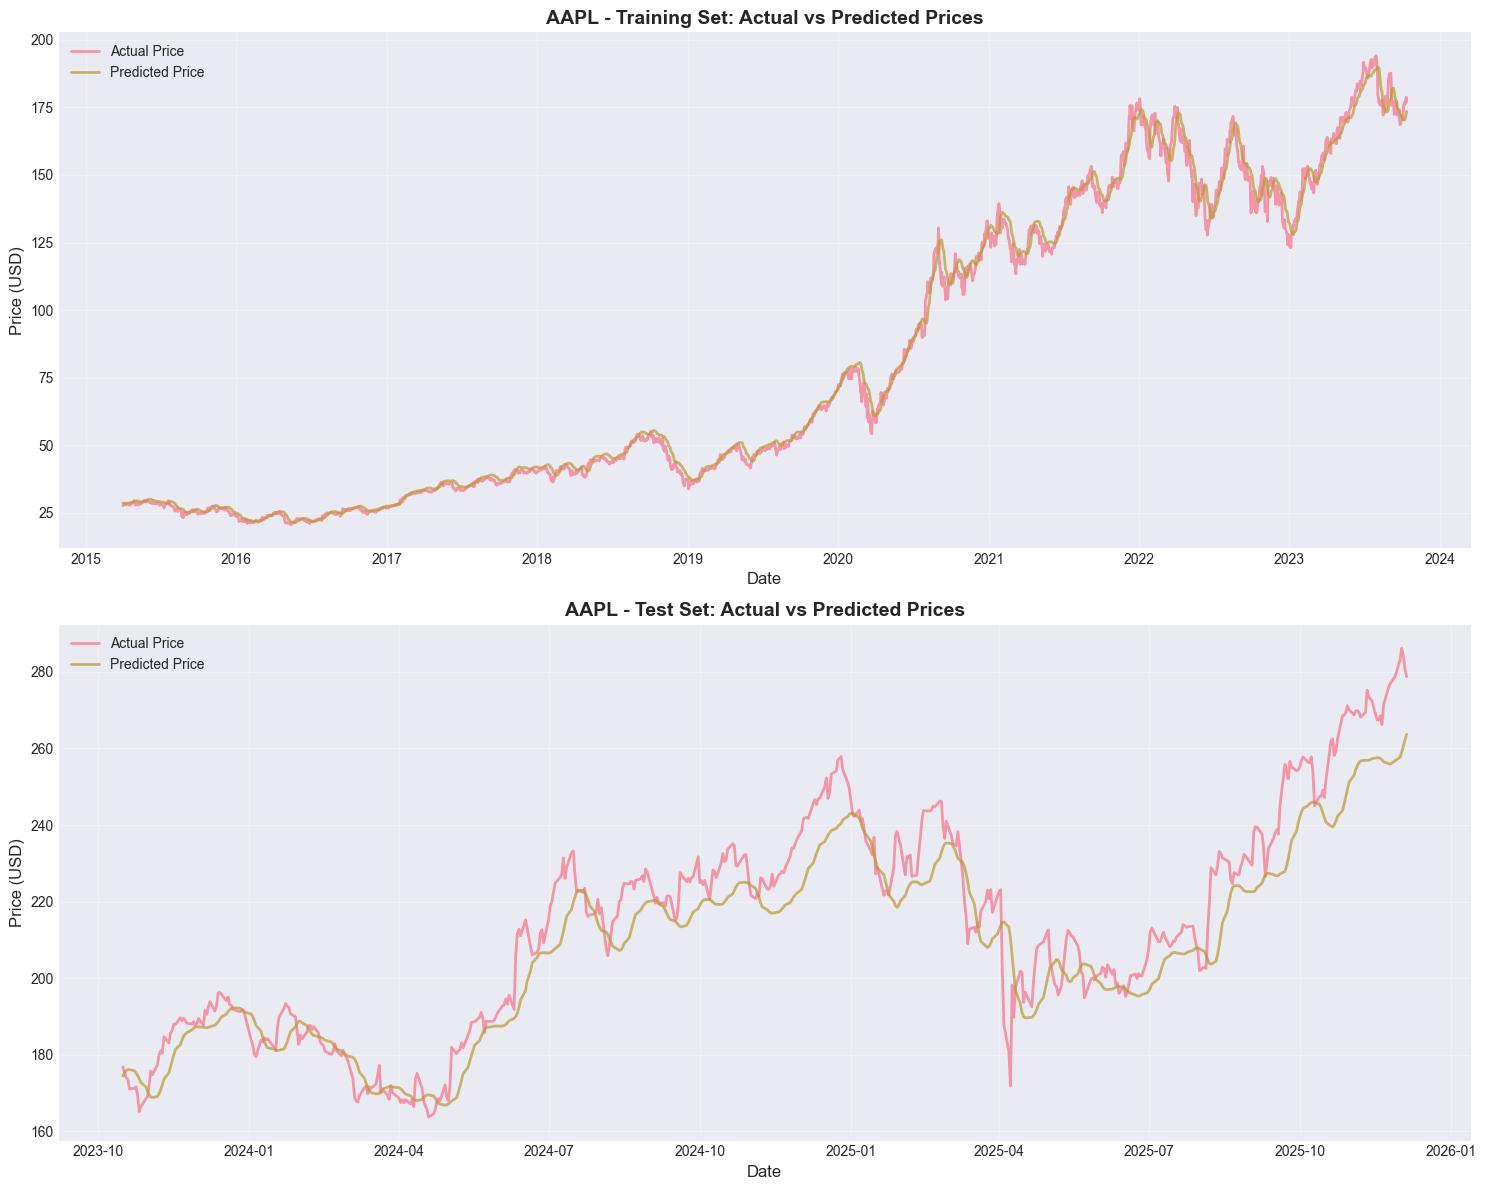

In [15]:
# Visualize predictions vs actual prices
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Training data
train_dates = df.index[SEQUENCE_LENGTH:SEQUENCE_LENGTH+len(train_predictions)]
axes[0].plot(train_dates, y_train_actual, label='Actual Price', linewidth=2, alpha=0.7)
axes[0].plot(train_dates, train_predictions, label='Predicted Price', linewidth=2, alpha=0.7)
axes[0].set_title(f'{STOCK_TICKER} - Training Set: Actual vs Predicted Prices', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price (USD)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test data
test_dates = df.index[SEQUENCE_LENGTH+len(train_predictions):SEQUENCE_LENGTH+len(train_predictions)+len(test_predictions)]
axes[1].plot(test_dates, y_test_actual, label='Actual Price', linewidth=2, alpha=0.7)
axes[1].plot(test_dates, test_predictions, label='Predicted Price', linewidth=2, alpha=0.7)
axes[1].set_title(f'{STOCK_TICKER} - Test Set: Actual vs Predicted Prices', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Price (USD)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

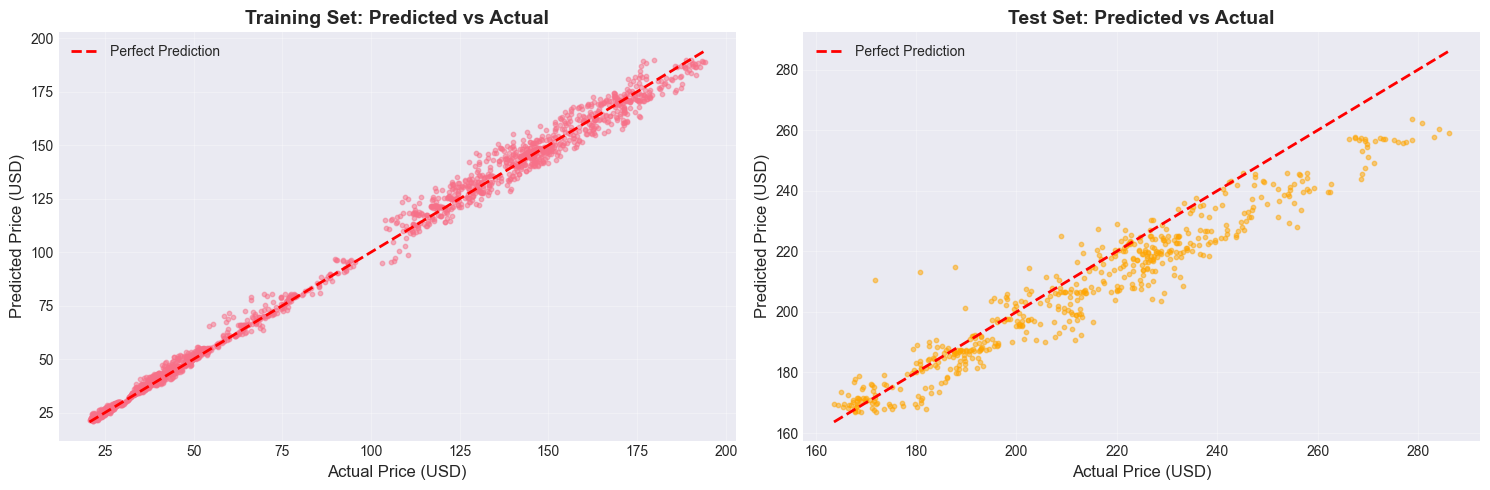

In [16]:
# Scatter plot of predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(y_train_actual, train_predictions, alpha=0.5, s=10)
axes[0].plot([y_train_actual.min(), y_train_actual.max()], 
             [y_train_actual.min(), y_train_actual.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_title('Training Set: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Price (USD)', fontsize=12)
axes[0].set_ylabel('Predicted Price (USD)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test_actual, test_predictions, alpha=0.5, s=10, color='orange')
axes[1].plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_title('Test Set: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Price (USD)', fontsize=12)
axes[1].set_ylabel('Predicted Price (USD)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Predict Future Prices

In [17]:
# Function to predict future prices
def predict_future(model, last_sequence, scaler, n_days):
    """
    Predict stock prices for the next n_days
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_days):
        # Reshape for prediction
        current_input = current_sequence.reshape((1, SEQUENCE_LENGTH, 1))
        
        # Predict next value
        next_pred = model.predict(current_input, verbose=0)[0, 0]
        predictions.append(next_pred)
        
        # Update sequence: remove first value and append prediction
        current_sequence = np.append(current_sequence[1:], next_pred)
    
    # Inverse transform to get actual prices
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    return predictions

# Get the last 60 days of data
last_sequence = scaled_data[-SEQUENCE_LENGTH:].flatten()

# Predict next 30 days
n_future_days = 30
future_predictions = predict_future(model, last_sequence, scaler, n_future_days)

print(f"Predicted prices for the next {n_future_days} days:")
print("="*60)

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_future_days, freq='D')

for date, price in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: ${price[0]:.2f}")

Predicted prices for the next 30 days:
2025-12-06: $264.82
2025-12-07: $264.98
2025-12-08: $264.18
2025-12-09: $262.62
2025-12-10: $260.53
2025-12-11: $258.12
2025-12-12: $255.55
2025-12-13: $252.95
2025-12-14: $250.39
2025-12-15: $247.89
2025-12-16: $245.49
2025-12-17: $243.19
2025-12-18: $240.99
2025-12-19: $238.89
2025-12-20: $236.88
2025-12-21: $234.95
2025-12-22: $233.11
2025-12-23: $231.34
2025-12-24: $229.66
2025-12-25: $228.04
2025-12-26: $226.49
2025-12-27: $225.00
2025-12-28: $223.57
2025-12-29: $222.20
2025-12-30: $220.88
2025-12-31: $219.61
2026-01-01: $218.39
2026-01-02: $217.21
2026-01-03: $216.07
2026-01-04: $214.97


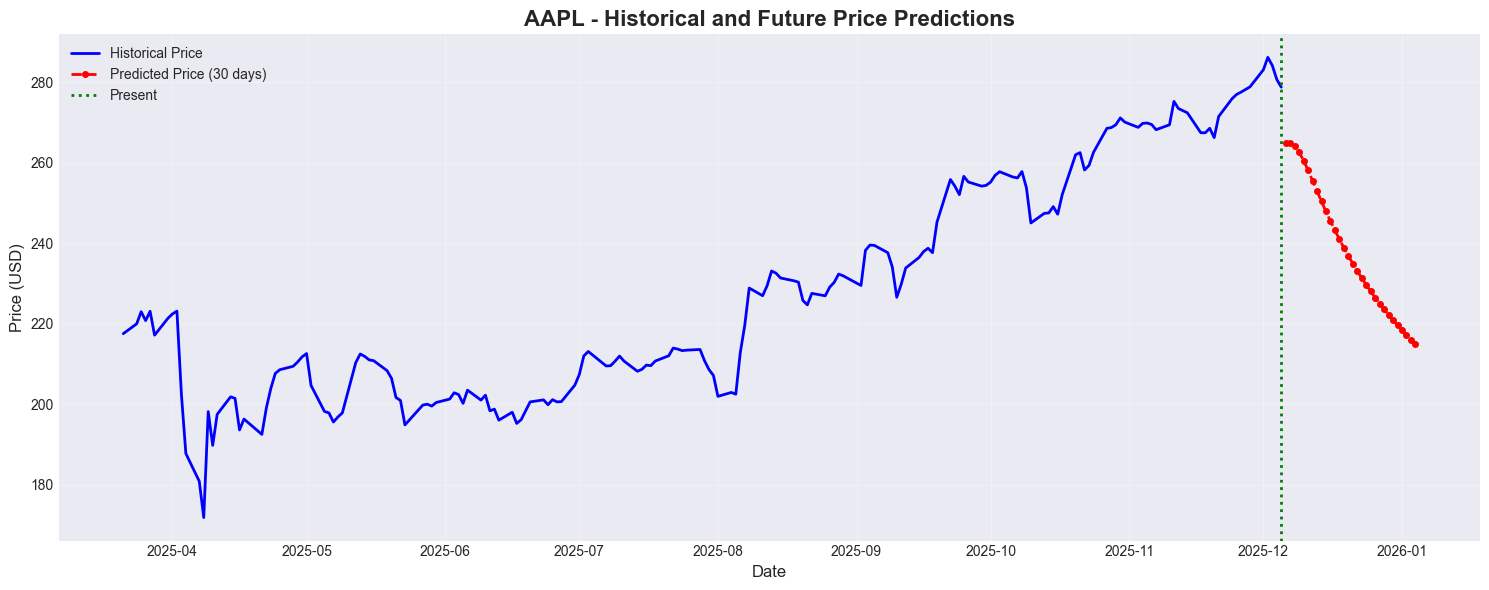


PREDICTION SUMMARY
Current Price:           $278.78
Predicted Price (30d):   $214.97
Expected Change:         $-63.81 (-22.89%)


In [18]:
# Visualize future predictions
plt.figure(figsize=(15, 6))

# Plot historical data (last 180 days)
historical_days = 180
plt.plot(df.index[-historical_days:], df['Close'][-historical_days:], 
         label='Historical Price', linewidth=2, color='blue')

# Plot future predictions
plt.plot(future_dates, future_predictions, 
         label=f'Predicted Price ({n_future_days} days)', 
         linewidth=2, color='red', linestyle='--', marker='o', markersize=4)

# Add vertical line at present
plt.axvline(x=last_date, color='green', linestyle=':', linewidth=2, label='Present')

plt.title(f'{STOCK_TICKER} - Historical and Future Price Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
current_price = df['Close'][-1]
predicted_price_30d = future_predictions[-1][0]
price_change = predicted_price_30d - current_price
percent_change = (price_change / current_price) * 100

print("\n" + "="*60)
print("PREDICTION SUMMARY")
print("="*60)
print(f"Current Price:           ${current_price:.2f}")
print(f"Predicted Price (30d):   ${predicted_price_30d:.2f}")
print(f"Expected Change:         ${price_change:.2f} ({percent_change:+.2f}%)")
print("="*60)

## 9. Save the Model

In [19]:
# Save the trained model
model.save('stock_price_prediction_model.h5')
print("Model saved as 'stock_price_prediction_model.h5'")

# Save the scaler for future use
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Model saved as 'stock_price_prediction_model.h5'
Scaler saved as 'scaler.pkl'


## 10. Summary and Recommendations

### Model Performance:
- The LSTM model was trained on historical stock data to predict future prices
- Evaluation metrics (RMSE, MAE, R2, MAPE) show model accuracy
- Lower RMSE and MAE values indicate better predictions
- Higher R2 score (closer to 1) indicates better fit

### Important Notes:
1. **This is for educational purposes only** - Stock prediction is inherently uncertain
2. **Do not use for actual trading decisions** without additional analysis
3. Past performance does not guarantee future results
4. Consider other factors: news, market sentiment, economic indicators
5. The model assumes patterns will continue, which may not be true

### Potential Improvements:
- Include additional features (volume, technical indicators, sentiment)
- Try different model architectures (GRU, Transformer)
- Implement ensemble methods
- Add attention mechanisms
- Use more sophisticated feature engineering
- Include external data (news, macro-economic indicators)